# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('ggplot')

#### Load Dataset

In [11]:
diamonds = pd.read_csv('../data/diamonds.csv', index_col=0)

#### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split

diamonds_train, diamonds_test = train_test_split(diamonds, test_size=0.25, random_state=0)

display(diamonds_train.info())
display(diamonds_train.describe())
display(diamonds_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 442 to 2733
Data columns (total 10 columns):
carat      40455 non-null float64
cut        40455 non-null object
color      40455 non-null object
clarity    40455 non-null object
depth      40455 non-null float64
table      40455 non-null float64
price      40455 non-null int64
x          40455 non-null float64
y          40455 non-null float64
z          40455 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


None

,carat,depth,table,price,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.797551,61.754901,57.452335,3928.059127,5.729940,5.733570,3.538183
std,0.474296,1.432185,2.228912,3987.094939,1.122544,1.151901,0.709761
min,0.200000,43.000000,43.000000,327.000000,0.000000,0.000000,0.000000
25%,0.400000,61.100000,56.000000,949.500000,4.710000,4.720000,2.910000
50%,0.700000,61.900000,57.000000,2398.000000,5.690000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5318.500000,6.540000,6.540000,4.040000
max,5.010000,79.000000,79.000000,18823.000000,10.740000,58.900000,31.800000


,carat,cut,color,clarity,depth,table,price,x,y,z
442,0.89,Premium,H,SI2,60.2,59.0,2815,6.26,6.23,3.76
50333,0.70,Very Good,D,SI1,64.0,53.0,2242,5.57,5.61,3.58
35653,0.31,Ideal,G,VVS2,62.7,57.0,907,4.33,4.31,2.71
9440,0.90,Very Good,H,VS1,62.3,59.0,4592,6.12,6.17,3.83
15825,1.01,Good,F,VS2,60.6,62.0,6332,6.52,6.49,3.94


#### Scatter Matrix

/home/benedict/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1080x1080 with 0 Axes>

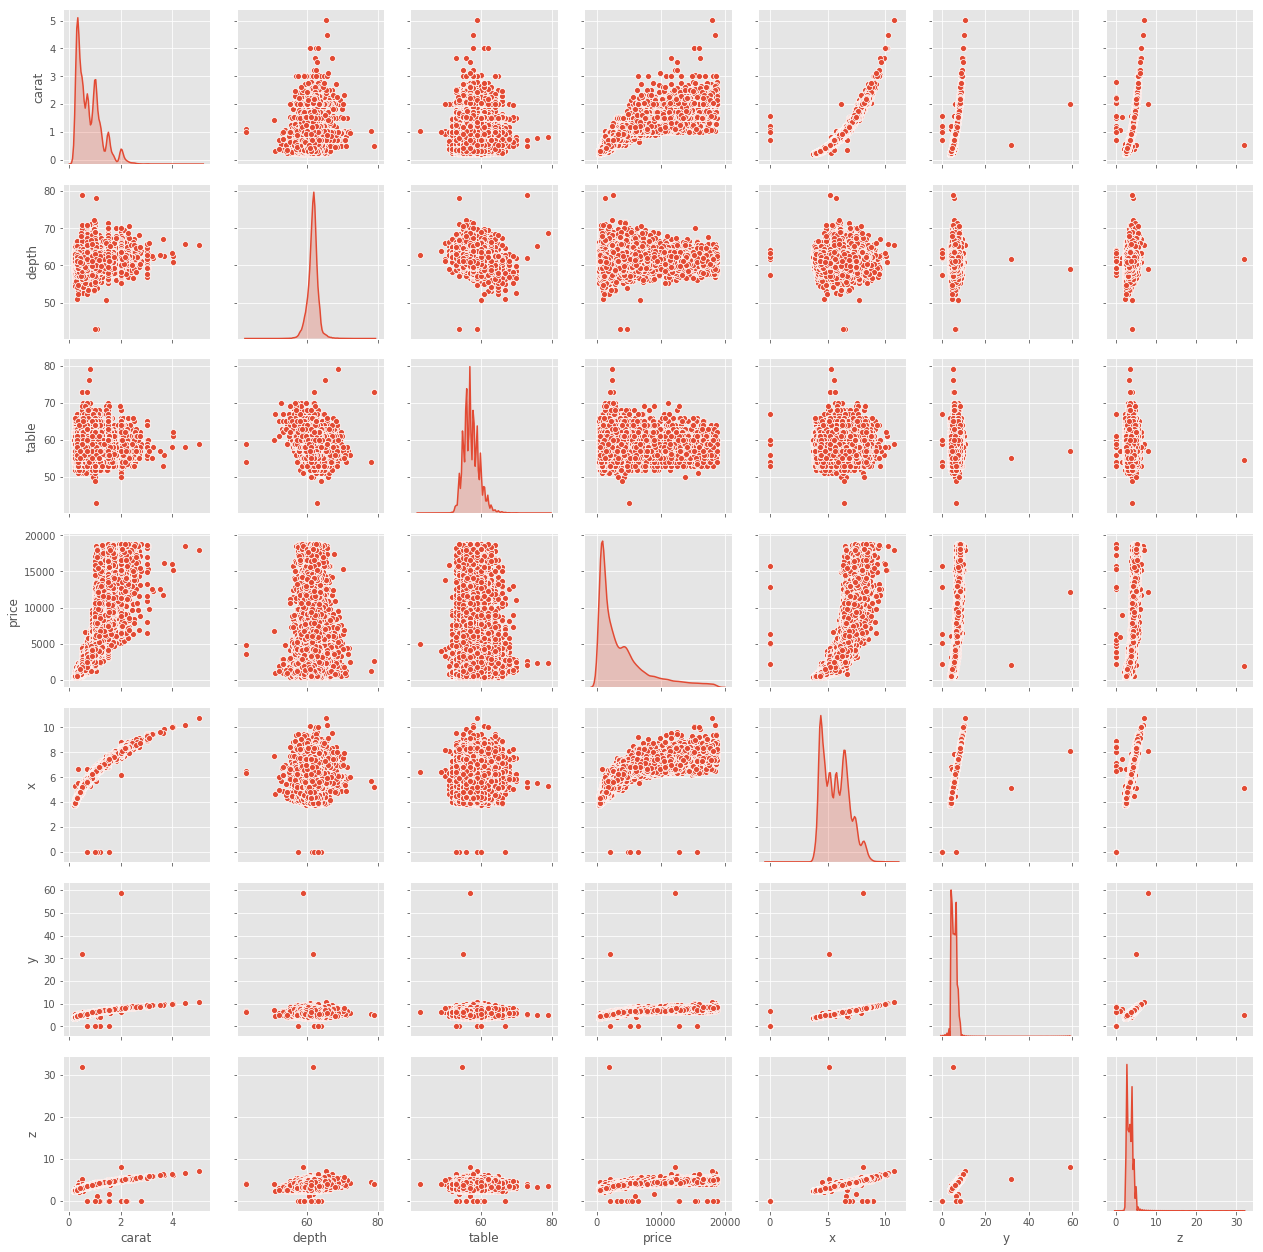

In [4]:
plt.figure(figsize=(15,15));
sns.pairplot(diamonds_train, diag_kind='kde');

## Univariate Analyses

### `carat`

Intuitively, I expect `carat` to be have a strong relationship with `price`.

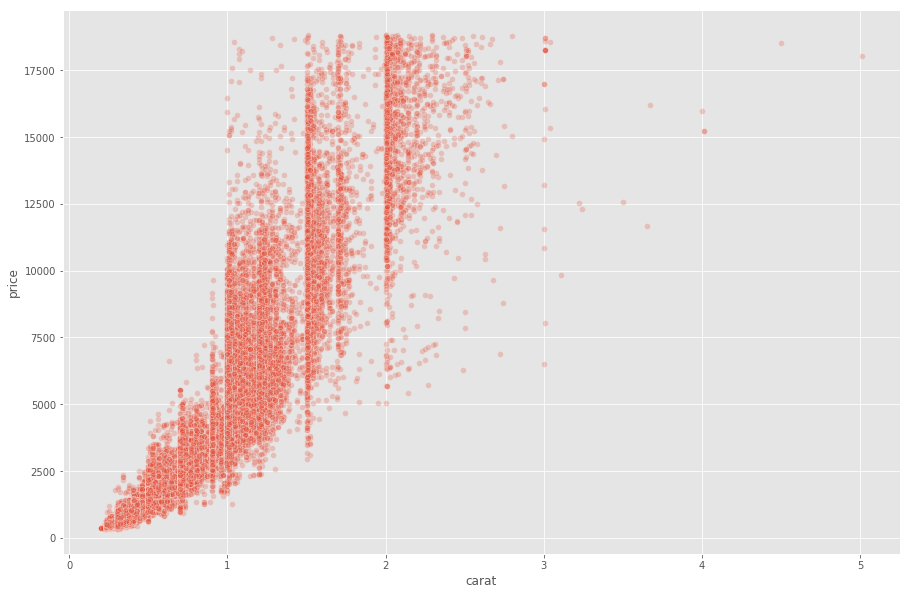

In [5]:
plt.figure(figsize=(15,10));
sns.scatterplot(x='carat', y='price', data=diamonds_train, alpha=0.25);

Looks relatively linear. There appears to be a heteroskedastic relationship between carat and price. I'll fit a univariate linear regression on price and carat and test the residuals with a Breusch-Pagan test.

####  Testing for Heteroskedasticity

In [6]:
import statsmodels.api as sm

In [7]:
y = diamonds_train['price'].values
X = sm.add_constant(diamonds_train['carat'].values)

lm_carat = sm.OLS(y, X)
lm_carat_fitted = lm_carat.fit()

lm_carat_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 2.273e+05
Date:                Tue, 18 Sep 2018   Prob (F-statistic):               0.00
Time:                        11:04:08   Log-Likelihood:            -3.5458e+05
No. Observations:               40455   AIC:                         7.092e+05
Df Residuals:                   40453   BIC:                         7.092e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2249.1841     15.076   -149.194      0.000   -2278.733   -2219.636
x1          7745.2608     16.247    476.732      0.000    7713.417    7777.105
==============================================================================
Omnibus:                    10571.958   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119237.641
Skew:                           0.935   Prob(JB):                         0.00
Kurtosis:                      11.200   Cond. No.                         3.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
y.shape

(40455,)

In [66]:
resids = lm_carat_fitted.resid

f_stat, p_val, alt = sm.stats.diagnostic.het_goldfeldquandt(y, X)

print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 0.9826393716744725
p-value: 0.8934893803484176


We fail to reject the null hypothesis that our data is homoskedastic.

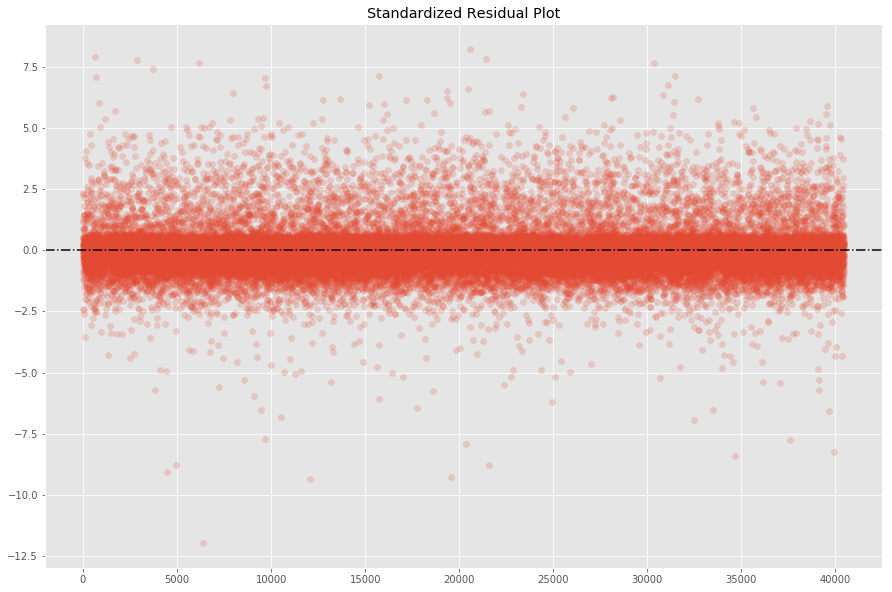

In [9]:
pearson_resids = lm_carat_fitted.resid_pearson

plt.figure(figsize=(15,10)); # I like big plots and I cannot lie
plt.scatter(x=range(len(resids)), y=pearson_resids, alpha=0.2);
plt.title("Standardized Residual Plot");
plt.axhline(c='black', ls='-.');

Looks good, let's move on.

#### Normal Distribution of Error

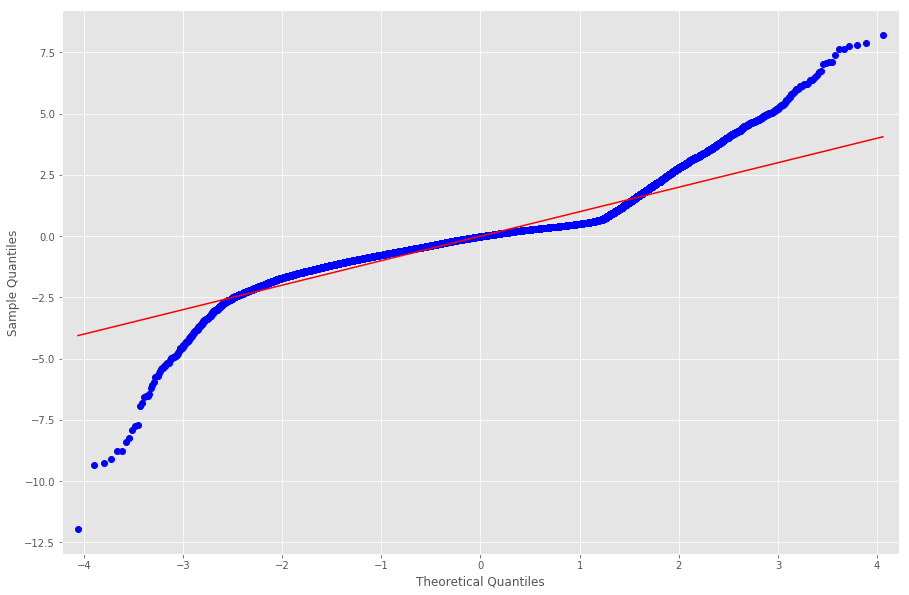

In [48]:
fig, ax = plt.subplots(figsize=(15,10));
sm.qqplot(pearson_resids, ax=ax, line='s');

Between this terrible looking Q-Q plot and the Jacques-Bera test, our error does not look normally distributed. Let's log transform this puppy.

#### Log-Transformation

In [43]:
lny = np.log(y)

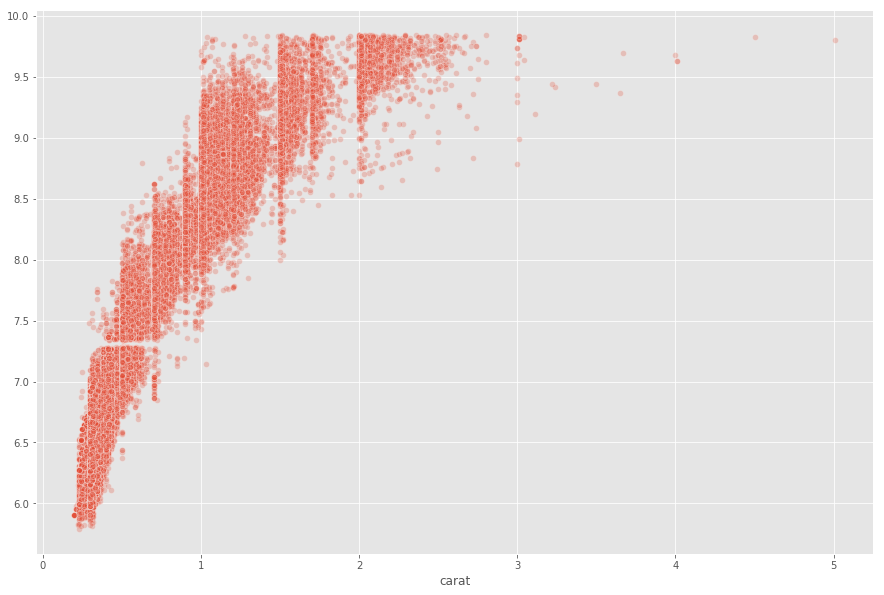

In [42]:
plt.figure(figsize=(15,10));
sns.scatterplot(x='carat', y=lny, data=diamonds_train, alpha=0.25);

This looks a lot better, quadratic probably.

In [40]:
lm_log_carat = sm.OLS(lny, X)
lm_log_carat_fitted = lm_log_carat.fit()

lm_log_carat_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 2.225e+05
Date:                Tue, 18 Sep 2018   Prob (F-statistic):               0.00
Time:                        11:18:21   Log-Likelihood:                -20087.
No. Observations:               40455   AIC:                         4.018e+04
Df Residuals:                   40453   BIC:                         4.020e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2182      0.004   1607.929      0.000       6.211       6.226
x1             1.9659      0.004    471.701      0.000       1.958       1.974
==============================================================================
Omnibus:                     8509.126   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61393.797
Skew:                          -0.825   Prob(JB):                         0.00
Kurtosis:                       8.805   Cond. No.                         3.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

JB test is still significant (large sample size :\) but the stat is much lower. Let's look at residuals.

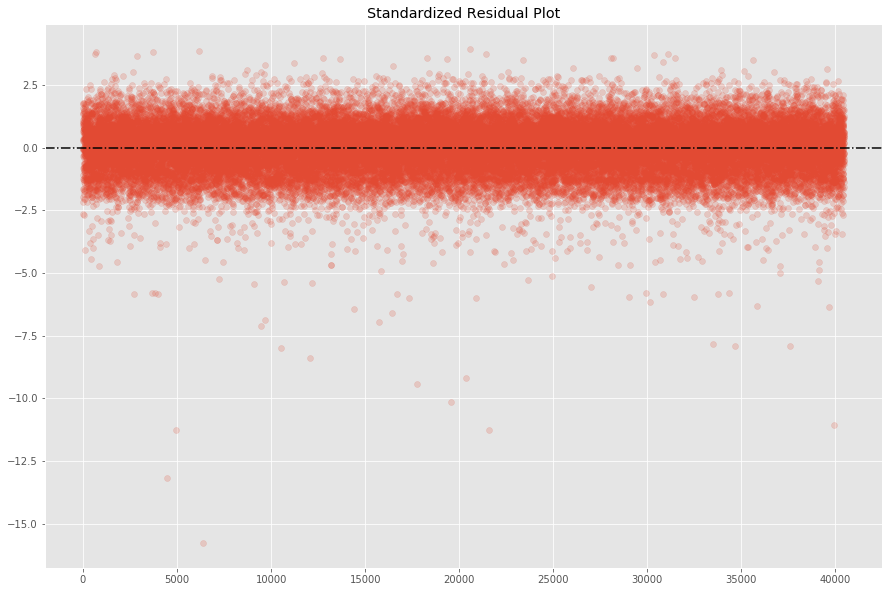

In [41]:
log_pearson_resids = lm_log_carat_fitted.resid_pearson

plt.figure(figsize=(15,10)); # I like big plots and I cannot lie
plt.scatter(x=range(len(resids)), y=log_pearson_resids, alpha=0.2);
plt.title("Standardized Residual Plot");
plt.axhline(c='black', ls='-.');

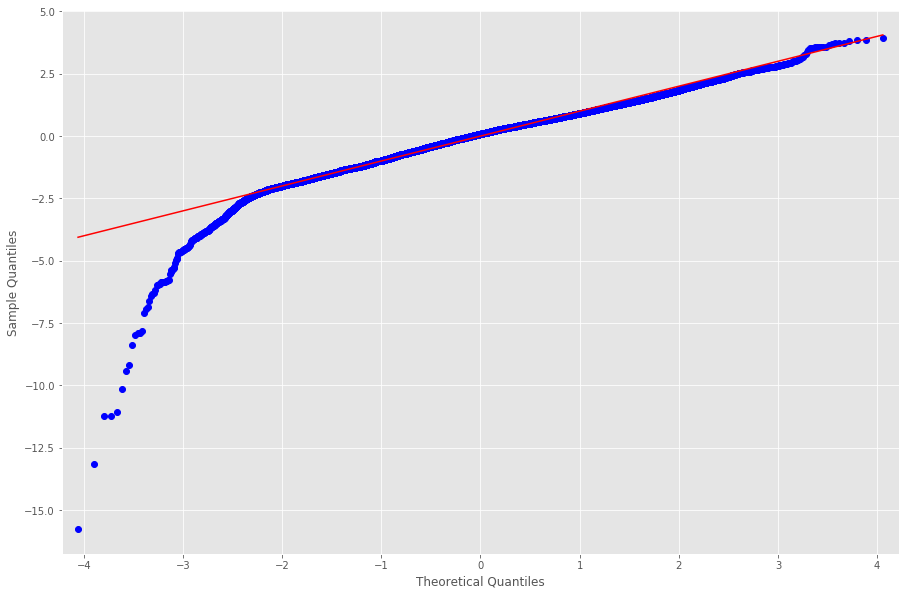

In [47]:
fig, ax = plt.subplots(figsize=(15,10));
sm.qqplot(log_pearson_resids, ax=ax, line='s');

Not perfect, but nothing is. Let's move on, it looks good enough. We will proceed using the natty log of price.

In [67]:
diamonds_train['lnprice'] = np.log(diamonds_train['price'])

#### Autocorrelation

Recall that our Durbin-Watson test statistic was 1.992, so we're good there.

#### Conclusion
So our univariate analysis of carat and price shows we have an $R^2$ of 0.846, I guess we can call it a day! Just kidding.